In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
from easyquery import Query
from fast3tree import fast3tree

In [21]:
VSDMPL_DATA = "/home/abs/Research/VSMDPL Data/MW_hosts_and_subs_Mr.parquet" # path to parquet

In [22]:
halos_and_subs = pd.read_parquet(VSDMPL_DATA)
halos_and_subs['num_satellites'] = halos_and_subs.groupby('upid')['upid'].transform('count')
halos_and_subs[halos_and_subs['upid']==12507653347]

,id,pid,upid,mvir,rvir,rs,mpeak,vmax,vmax_mpeak,halfmass_scale,x,y,z,vx,vy,vz,b_to_a,c_to_a,Mr,num_satellites
7519,12507653160,12507653347,12507653347,2.528100e+08,12.866000,0.495,3.206400e+08,14.270000,13.830000,0.2959,12.31873,13.05603,20.722300,-100.339996,321.850006,-10.860000,0.54004,0.40016,NaN,61
7520,12507653348,12507653347,12507653347,2.404800e+08,12.653000,0.304,8.694300e+08,16.270000,23.530001,0.1942,12.44897,13.02027,20.814581,144.660004,84.040001,216.199997,0.67433,0.60096,NaN,61
7521,12507653161,12507653347,12507653347,2.281500e+08,12.433000,0.690,2.713100e+08,12.410000,13.990000,0.3021,12.20948,12.99193,20.839920,92.940002,217.270004,-262.239990,0.91500,0.70237,NaN,61
7522,12507653195,12507653347,12507653347,1.664900e+08,11.194000,0.631,3.021400e+08,11.120000,12.470000,0.2028,12.41824,12.95316,20.963949,11.680000,209.710007,-205.399994,0.65737,0.45570,NaN,61
7523,12507653342,12507653347,12507653347,1.911500e+08,11.721000,0.756,2.774800e+08,11.230000,14.630000,0.3534,12.32660,13.04352,20.943451,-60.080002,133.529999,150.830002,0.69340,0.35326,NaN,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7575,12507653349,12507653347,12507653347,1.171600e+09,21.450001,0.131,2.891900e+09,27.430000,34.970001,0.2217,12.41583,13.05530,20.885450,33.419998,-6.460000,-48.169998,0.97878,0.86141,-5.943570,61
7576,12507653337,12507653346,12507653347,5.204200e+09,35.261002,0.333,1.284400e+10,42.520000,51.049999,0.3534,12.31371,13.01992,20.806511,286.950012,223.740005,229.839996,0.77029,0.72229,-9.947418,61
7577,12507653062,12507653347,12507653347,9.619200e+08,20.086000,1.047,1.356600e+09,20.389999,24.059999,0.1984,12.51803,12.93509,20.869749,212.509995,1.350000,123.720001,0.60274,0.54337,NaN,61
7578,12507653346,12507653347,12507653347,2.721100e+10,61.201000,9.406,4.188100e+10,49.270000,61.750000,0.2959,12.35569,12.98725,20.814270,-0.460000,14.920000,-69.000000,0.47737,0.42779,-12.264562,61


<h2>Add corrected positions</h2>

- if x - x_host > box_length/2, shift by -box_length

- if x - x_host < -box_length/2 shift by +box_length

<h4>Add host x, y, z</h4>

In [23]:
halos, subs = Query("upid == -1").split(halos_and_subs)
subs = pd.merge(subs, halos, how="left", left_on="upid", right_on="id", suffixes=("", "_host")).sort_values(by='upid')
subs

,id,pid,upid,mvir,rvir,rs,mpeak,vmax,vmax_mpeak,halfmass_scale,...,x_host,y_host,z_host,vx_host,vy_host,vz_host,b_to_a_host,c_to_a_host,Mr_host,num_satellites_host
0,12507603666,12507603697,12507603697,2.959800e+08,13.560000,0.736,3.761400e+08,13.610000,13.960000,0.2959,...,5.420090,2.990690,8.149510,-76.040001,15.03,8.470000,0.82758,0.64402,-19.314664,7124
66,12507603618,12507603697,12507603697,4.624600e+08,15.735000,0.775,5.981200e+08,16.230000,17.500000,0.3610,...,5.420090,2.990690,8.149510,-76.040001,15.03,8.470000,0.82758,0.64402,-19.314664,7124
65,12507603593,12507603697,12507603697,9.680900e+08,20.129000,1.497,9.865900e+08,19.480000,20.590000,0.3165,...,5.420090,2.990690,8.149510,-76.040001,15.03,8.470000,0.82758,0.64402,-19.314664,7124
64,12507603654,12507603697,12507603697,6.782800e+07,8.298000,0.458,1.109900e+08,8.290000,10.640000,0.5495,...,5.420090,2.990690,8.149510,-76.040001,15.03,8.470000,0.82758,0.64402,-19.314664,7124
63,12507603695,12507603697,12507603697,1.029700e+09,20.547001,0.028,2.862900e+10,29.400000,67.800003,0.3300,...,5.420090,2.990690,8.149510,-76.040001,15.03,8.470000,0.82758,0.64402,-19.314664,7124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376461,12570939080,12570939085,12570939085,7.288400e+09,39.451000,1.095,7.559700e+09,39.880001,40.049999,0.3021,...,143.370041,155.316757,156.535843,-433.890015,-52.73,-307.690002,0.90205,0.72945,-19.911082,7124
376459,12570939087,12570939085,12570939085,4.932900e+07,7.462000,1.583,7.646000e+08,5.620000,26.549999,0.1661,...,143.370041,155.316757,156.535843,-433.890015,-52.73,-307.690002,0.90205,0.72945,-19.911082,7124
376468,12570939066,12570939085,12570939085,8.016000e+07,8.773000,1.627,1.541500e+08,6.730000,11.790000,0.2833,...,143.370041,155.316757,156.535843,-433.890015,-52.73,-307.690002,0.90205,0.72945,-19.911082,7124
376463,12570939082,12570939085,12570939085,2.466500e+07,5.923000,0.582,3.206400e+08,5.120000,14.030000,0.2770,...,143.370041,155.316757,156.535843,-433.890015,-52.73,-307.690002,0.90205,0.72945,-19.911082,7124


<h4>Add adjusted positions x_adj, y_adj, z_adj</h4>

In [24]:
box_len = 160
subs['x_adj'] = subs['x']
subs.loc[subs['x'] - subs['x_host'] > box_len/2, 'x_adj'] = subs['x'] - 160
subs.loc[subs['x'] - subs['x_host'] < -box_len/2, 'x_adj'] = subs['x'] + 160

subs['y_adj'] = subs['y']
subs.loc[subs['y'] - subs['y_host'] > box_len/2, 'y_adj'] = subs['y'] - 160
subs.loc[subs['y'] - subs['y_host'] < -box_len/2, 'y_adj'] = subs['y'] + 160


subs['z_adj'] = subs['z']
subs.loc[subs['z'] - subs['z_host'] > box_len/2, 'z_adj'] = subs['z'] - 160
subs.loc[subs['z'] - subs['z_host'] < -box_len/2, 'z_adj'] = subs['z'] + 160

<h2>Make cuts to get SAGA-like data</h2>
<h4>Current cuts</h4>

- vmax_mpeak >= 45 (following vmax_mpeak vs # satellites & using saga # satellites average)

- 3 or more satellites

<h4>Unused cuts</h4>

- mvir >= 1e10

In [25]:
# Filter by most massive
# subs = df[df['mvir'] >= 1e10]

# Use vmax_mpeak as proxy for luminosity
subs_cut = subs[subs['vmax_mpeak'] >= 52.77]

## Grab Interlopers

In [39]:
# threshold redshift
dz_thres = 2.75

In [38]:
subs_cut["z_vz"] = np.remainder(subs_cut["z"] + subs_cut["vz"] / 100.0, box_len)
subs_cut["z_vz"] = np.remainder(subs_cut["z"] + subs_cut["vz"] / 100.0, box_len)

In [26]:
############### This groups by ID. NO for interlopers)
# Select only satellite systems with 3 or more members
subs_cut = subs_cut.groupby(['upid']).filter(lambda x: len(x) > 2)
subs_cut

,id,pid,upid,mvir,rvir,rs,mpeak,vmax,vmax_mpeak,halfmass_scale,...,vx_host,vy_host,vz_host,b_to_a_host,c_to_a_host,Mr_host,num_satellites_host,x_adj,y_adj,z_adj
63,12507603695,12507603697,12507603697,1.029700e+09,20.547001,0.028,2.862900e+10,29.400000,67.800003,0.3300,...,-76.040001,15.030000,8.470000,0.82758,0.64402,-19.314664,7124,5.433750,2.984800,8.122120
48,12507603693,12507603697,12507603697,1.720400e+09,24.381001,0.064,3.504200e+10,30.040001,64.330002,0.3534,...,-76.040001,15.030000,8.470000,0.82758,0.64402,-19.314664,7124,5.409690,2.953880,8.122570
80,12507603691,12507603697,12507603697,3.403700e+09,30.608000,1.114,1.420100e+10,35.830002,53.810001,0.2770,...,-76.040001,15.030000,8.470000,0.82758,0.64402,-19.314664,7124,5.436800,3.018230,8.237920
18,12507603687,12507603697,12507603697,9.584100e+10,93.116997,8.262,1.114900e+11,81.620003,87.089996,0.4310,...,-76.040001,15.030000,8.470000,0.82758,0.64402,-19.314664,7124,5.422080,2.896960,7.993020
152,12507603796,12507603892,12507603892,2.069400e+10,55.862999,3.027,2.888200e+10,54.880001,60.810001,0.4505,...,-17.570000,-106.349998,-65.129997,0.55137,0.39224,-18.881284,7124,5.162390,3.018370,8.405890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376329,12570938695,12570938703,12570938703,1.285000e+10,47.660000,1.205,2.972100e+10,51.830002,61.680000,0.3378,...,-346.510010,-123.330002,-271.329987,0.90840,0.69628,-18.769242,7124,140.550125,154.535629,151.818771
376327,12570938705,12570938703,12570938703,7.670700e+09,40.129002,0.218,3.700300e+10,52.470001,72.739998,0.2770,...,-346.510010,-123.330002,-271.329987,0.90840,0.69628,-18.769242,7124,140.571701,154.544724,152.071381
376424,12570938872,12570938875,12570938875,2.265400e+10,57.575001,1.325,3.155200e+10,59.139999,57.709999,0.4115,...,-204.899994,-107.629997,-319.779999,0.69200,0.65381,-18.921900,7124,153.025391,155.312012,152.844269
376418,12570938873,12570938872,12570938875,3.527000e+09,30.973000,0.072,2.001500e+10,41.900002,57.439999,0.2475,...,-204.899994,-107.629997,-319.779999,0.69200,0.65381,-18.921900,7124,153.066330,155.290955,152.853012


In [27]:
average_num_subs = len(subs_cut)/len(subs_cut['upid'].unique())
average_num_subs

3.878005023322569

In [28]:
test_subs_cut = subs_cut.copy()
test_subs_cut['test_column'] = test_subs_cut[test_subs_cut['vmax_mpeak'] >= 50].groupby('upid')['upid'].transform('count')
test_subs_cut
average = test_subs_cut[test_subs_cut['test_column'] > 2]['test_column']
average

63        4
48        4
80        4
18        4
152       6
         ..
376329    4
376327    4
376424    3
376418    3
376411    3
Name: test_column, Length: 10808, dtype: int64

<h2>Ellipticity calculations</h2>

In [29]:
data = subs_cut

<h4>Quadrupole moments</h4>

In [30]:
ellipticity_df = data.copy()
ellipticity_df['x_diff_sq'] = (ellipticity_df['x_adj'] - ellipticity_df['x_host'])**2
ellipticity_df['y_diff_sq'] = (ellipticity_df['y_adj'] - ellipticity_df['y_host'])**2
ellipticity_df['x_diff_y_diff'] = (ellipticity_df['y_adj'] - ellipticity_df['y_host'])*(ellipticity_df['x_adj'] - ellipticity_df['x_host'])
ellipticity_df = ellipticity_df.groupby('upid', as_index = False)['x_diff_sq', 'y_diff_sq', 'x_diff_y_diff'].mean().rename(columns={'x_diff_sq':'Q_xx', 'y_diff_sq':'Q_yy', 'x_diff_y_diff':'Q_xy'})
ellipticity_df

/tmp/ipykernel_39594/3601858832.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ellipticity_df = ellipticity_df.groupby('upid', as_index = False)['x_diff_sq', 'y_diff_sq', 'x_diff_y_diff'].mean().rename(columns={'x_diff_sq':'Q_xx', 'y_diff_sq':'Q_yy', 'x_diff_y_diff':'Q_xy'})


,upid,Q_xx,Q_yy,Q_xy
0,12507603697,0.000144,0.002733,0.000144
1,12507603892,0.004366,0.006649,0.004113
2,12507604502,0.001908,0.003257,0.001493
3,12507605205,0.005125,0.009319,-0.003469
4,12507658991,0.006253,0.003780,0.003765
...,...,...,...,...
2782,12570911041,0.000711,0.003011,-0.000389
2783,12570937404,0.003512,0.006784,-0.003428
2784,12570938672,0.002610,0.001291,0.001395
2785,12570938703,0.002630,0.002671,-0.000154



<h4>Ellipticity components</h4>

In [31]:
def e_1 (Q_xx, Q_yy, Q_xy):
    return (( Q_xx - Q_yy )/(Q_xx + Q_yy + 2*(Q_xx*Q_yy-Q_xy**2)**(1/2)))
def e_2 (Q_xx, Q_yy, Q_xy):
    return (2*Q_xy/(Q_xx + Q_yy + 2*(Q_xx*Q_yy-Q_xy**2)**(1/2)))
def e_3 (e_1, e_2):
    return ( e_1**2 + e_2**2 )**(1/2)


ellipticity_df['e_1'] = e_1(ellipticity_df['Q_xx'], ellipticity_df['Q_yy'], ellipticity_df['Q_xy'])
ellipticity_df['e_2'] = e_2(ellipticity_df['Q_xx'], ellipticity_df['Q_yy'], ellipticity_df['Q_xy'])
ellipticity_df['e_3'] = e_3(ellipticity_df['e_1'], ellipticity_df['e_2'])

In [32]:
# sns.set(style="darkgrid", palette="viridis")
custom_style = {
    "figure.facecolor": "212946",
    "axes.facecolor": "212946",
    "savefig.facecolor": "212946", 
    "grid.color": "2A3459",
    "text.color": "0.9",
    "axes.labelcolor": "0.9",
    "xtick.color": "0.9",
    "ytick.color": "0.9",
    "grid.linestyle": "-",
    "lines.solid_capstyle": "round"
}

sns.set_style("darkgrid", custom_style)

<AxesSubplot: xlabel='e_3', ylabel='Density'>

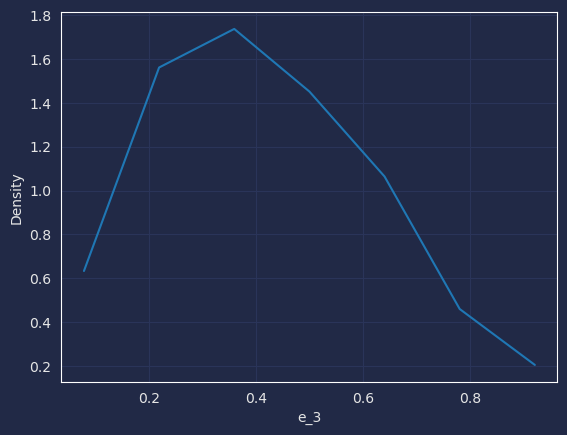

In [33]:
sns.histplot(ellipticity_df["e_3"], bins=7, element='poly', stat="density", fill=False)

In [34]:
# check about the high ellipticity bois
high_ellipticity_halo_ids = ellipticity_df[ellipticity_df['e_3'] >= 0.9]['upid'].unique()
high_ellipticity_data = data[data['upid'].isin(high_ellipticity_halo_ids)]

high_ellipticity_halos = high_ellipticity_data.groupby(['upid'])['id'].count()
average_count_high_ellipticity = high_ellipticity_halos.mean()
print("Average number of satellites per halo for the high-eccentricity data: {}".format(average_count_high_ellipticity))

all_halos = data.groupby(['upid'])['id'].count()
average_count_all = all_halos.mean()
print("Average number of satellites per halo for entire data set: {}".format(average_count_all))


Average number of satellites per halo for the high-eccentricity data: 3.1333333333333333
Average number of satellites per halo for entire data set: 3.878005023322569


<h4>Store ellipticity DataFrame to use in other nbs</h4>

In [35]:
ellipticity_df_VSMDPL = ellipticity_df
%store ellipticity_df_VSMDPL

Stored 'ellipticity_df_VSMDPL' (DataFrame)


In [36]:
display(ellipticity_df)

,upid,Q_xx,Q_yy,Q_xy,e_1,e_2,e_3
0,12507603697,0.000144,0.002733,0.000144,-0.631239,0.070229,0.635133
1,12507603892,0.004366,0.006649,0.004113,-0.127046,0.457545,0.474856
2,12507604502,0.001908,0.003257,0.001493,-0.147375,0.326235,0.357978
3,12507605205,0.005125,0.009319,-0.003469,-0.158883,-0.262860,0.307147
4,12507658991,0.006253,0.003780,0.003765,0.152803,0.465223,0.489675
...,...,...,...,...,...,...,...
2782,12570911041,0.000711,0.003011,-0.000389,-0.351408,-0.118837,0.370957
2783,12570937404,0.003512,0.006784,-0.003428,-0.189731,-0.397585,0.440535
2784,12570938672,0.002610,0.001291,0.001395,0.209834,0.443716,0.490830
2785,12570938703,0.002630,0.002671,-0.000154,-0.003863,-0.029090,0.029346


<h2>Highest luminosity analysis</h2>

In [21]:
highest_luminosity_subs = halos_and_subs.groupby('upid', as_index = False)['Mr', 'num_satellites'].min()

/tmp/ipykernel_27553/381654544.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  highest_luminosity_sats = hosts_and_sats.groupby('upid', as_index = False)['Mr', 'num_satellites'].min()


In [22]:
highest_luminosity_ellipticity = pd.merge(highest_luminosity_subs, ellipticity_df, how="left", left_on="upid", right_on="upid")[['upid', 'Mr', 'e_3']]

In [23]:
# get rid of halos which were filtered out by 
highest_luminosity_ellipticity_VSMDPL = highest_luminosity_ellipticity[~highest_luminosity_ellipticity['e_3'].isna()]
%store highest_luminosity_ellipticity_VSMDPL
highest_luminosity_ellipticity_VSMDPL

Stored 'highest_luminosity_ellipticity_VSMDPL' (DataFrame)


,upid,Mr,e_3
1,12507603697,-15.275099,0.635133
2,12507603892,-13.924031,0.474856
3,12507604502,-15.946791,0.357978
4,12507605205,-14.945121,0.307147
6,12507658991,-16.310917,0.489675
...,...,...,...
7111,12570911041,-13.505959,0.370957
7115,12570937404,-18.171334,0.440535
7117,12570938672,-16.204040,0.490830
7118,12570938703,-15.334453,0.029346


<h2>Concat highest luminosity w/ log(vmax_mpeak)</h2>

In [24]:
highest_vmax_subs = halos_and_subs.groupby('upid', as_index = False)['vmax_mpeak'].max()

In [25]:
highest_vmax_ellipticity = pd.merge(highest_vmax_subs, ellipticity_df, how="left", left_on="upid", right_on="upid")[['upid', 'vmax_mpeak', 'e_3']]
highest_vmax_ellipticity

,upid,vmax_mpeak,e_3
0,-1,339.589996,NaN
1,12507603697,87.089996,0.635133
2,12507603892,78.349998,0.474856
3,12507604502,100.989998,0.357978
4,12507605205,91.239998,0.307147
...,...,...,...
7120,12570938858,102.820000,NaN
7121,12570938875,57.709999,0.107672
7122,12570938949,71.760002,NaN
7123,12570939057,106.419998,NaN


In [26]:
highest_vmax_ellipticity['log_vmax_mpeak'] = np.log(highest_vmax_ellipticity['vmax_mpeak'])

In [27]:
highest_vmax_ellipticity_VSMDPL = highest_vmax_ellipticity[~highest_vmax_ellipticity['e_3'].isna()]
%store highest_vmax_ellipticity_VSMDPL
highest_vmax_ellipticity_VSMDPL

Stored 'highest_vmax_ellipticity_VSMDPL' (DataFrame)


,upid,vmax_mpeak,e_3,log_vmax_mpeak
1,12507603697,87.089996,0.635133,4.466942
2,12507603892,78.349998,0.474856,4.361186
3,12507604502,100.989998,0.357978,4.615022
4,12507605205,91.239998,0.307147,4.513494
6,12507658991,105.860001,0.489675,4.662117
...,...,...,...,...
7111,12570911041,78.309998,0.370957,4.360675
7115,12570937404,136.279999,0.440535,4.914711
7117,12570938672,92.489998,0.490830,4.527101
7118,12570938703,97.750000,0.029346,4.582413


In [28]:
import matplotlib.pyplot as plt

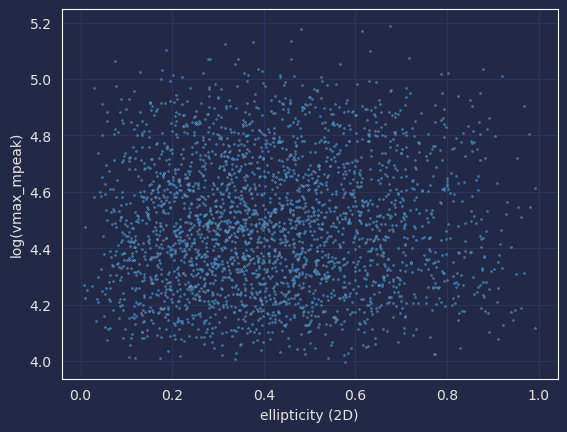

In [29]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('ellipticity (2D)')
ax1.set_ylabel('log(vmax_mpeak)')
sp1 = sns.scatterplot(data=highest_vmax_ellipticity_VSMDPL, x='e_3', y='log_vmax_mpeak', ax=ax1, s=2)

In [30]:
fig = sp1.figure.get_figure()
fig.set_size_inches([6, 4])
fig.savefig("SimVmax_mpeakVsEllipticity.png",dpi=600)

<h2>Average # satellites per vmax_mpeak</h2>

In [31]:
halos_num_vmax = subs.groupby('upid').first()[['vmax_mpeak_host', 'num_satellites']]
halos_num_vmax

,vmax_mpeak_host,num_satellites
upid,,
12507603697,173.779999,92
12507603892,151.250000,112
12507604502,177.199997,101
12507605205,163.729996,90
12507653347,176.259995,61
...,...,...
12570938858,161.850006,35
12570938875,167.880005,20
12570938949,164.600006,16


Bin halos by vmax_mpeak

In [32]:
halos_num_vmax_averages = halos_num_vmax.groupby(pd.cut(halos_num_vmax['vmax_mpeak_host'], np.linspace(135, 340, 20))).mean()
halos_num_vmax_averages

,vmax_mpeak_host,num_satellites
vmax_mpeak_host,,
"(135.0, 145.789]",142.225723,59.780488
"(145.789, 156.579]",152.416504,60.483568
"(156.579, 167.368]",162.648468,57.008045
"(167.368, 178.158]",172.886353,53.030739
"(178.158, 188.947]",183.248627,52.198623
"(188.947, 199.737]",193.377060,49.325911
"(199.737, 210.526]",203.945221,46.672355
"(210.526, 221.316]",214.434937,41.849462
"(221.316, 232.105]",226.217499,36.531250


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

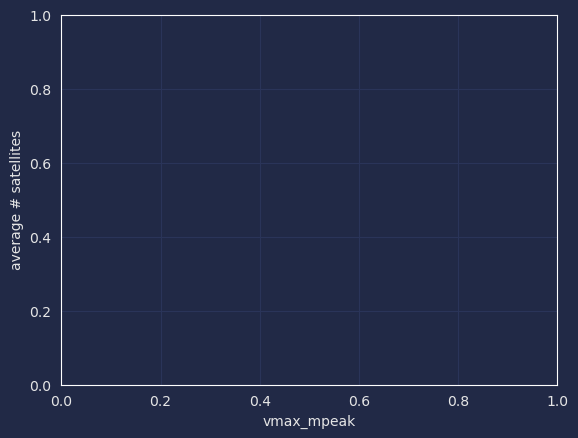

In [33]:
fig2, ax2 = plt.subplots()
ax2.set_xlabel('vmax_mpeak')
ax2.set_ylabel('average # satellites')
sp2 = sns.lineplot(halos_num_vmax_averages['vmax_mpeak_host'], halos_num_vmax_averages['num_satellites'], ax=ax2)

In [34]:
fig2 = sp2.figure.get_figure()
fig2.set_size_inches([6, 4])
fig2.savefig("NumsubsVsVmax_mpeak.png",dpi=600)

NameError: name 'sp2' is not defined

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

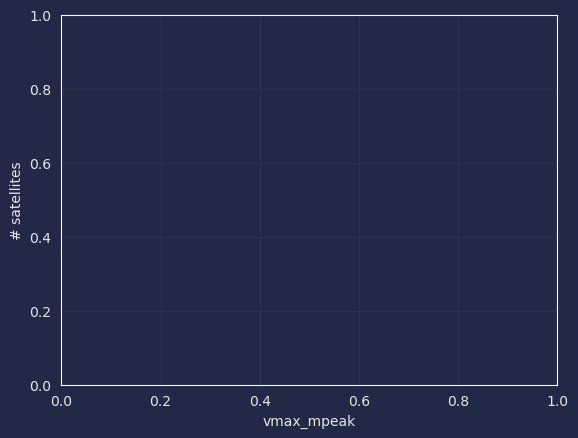

In [35]:
fig3, ax3 = plt.subplots()
ax3.set_xlabel('vmax_mpeak')
ax3.set_ylabel('# satellites')
sp3 = sns.scatterplot(halos_num_vmax['vmax_mpeak_host'], halos_num_vmax['num_satellites'], ax=ax3, s=2)

In [ ]:
import scipy as sp
spearmanr_results = sp.stats.spearmanr(halos_num_vmax['vmax_mpeak_host'], halos_num_vmax['num_satellites'], axis=0, nan_policy='propagate', alternative='two-sided')
spearmanr_results

In [ ]:
fig3 = sp3.figure.get_figure()
fig3.set_size_inches([6, 4])
fig3.savefig("NumsubsVsVmax_mpeak_scatter.png",dpi=600)